## antes de iniciar o projeto instalei o pacote da biblioteca spacy para trablhar com a linguagem em português, com o comando 

## python -m spacy download pt_core_news_sm

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy 
import nltk
import re 
from nltk import word_tokenize
from nltk.util import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from spacy.lang.pt import Portuguese
from spacy import displacy
import pyLDAvis.lda_model

import warnings
warnings.filterwarnings('ignore')

In [5]:
nltk.download('punkt') # baixar tratamento de pontuações

[nltk_data] Downloading package punkt to /home/marcos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Conjunto de dados

In [6]:
news = pd.read_csv('articles.csv')

In [7]:
news.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [8]:
turismo = news[news['category'] == 'turismo']

In [9]:
turismo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1903 entries, 381 to 167031
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1903 non-null   object
 1   text         1903 non-null   object
 2   date         1903 non-null   object
 3   category     1903 non-null   object
 4   subcategory  0 non-null      object
 5   link         1903 non-null   object
dtypes: object(6)
memory usage: 104.1+ KB


In [10]:
def limpa_texto(texto):
    c = re.sub(r'\n', ' ', texto)
    c = re.sub(r'\r', ' ', c)
    

    c = c.replace(':', '')
    c = c.replace('/', '')
    c = re.sub(r'R\$', '', c)
    c = re.sub(r'\W', ' ', c)
    c = re.sub(r'\W', ' ', c)

    c = re.sub(r'\s+', ' ', c)
    c = re.sub(r'^\s+', '', c)
    c = re.sub(r'\s+$', '', c)

    return c.lower()

In [11]:
STOP_WORDS = spacy.lang.pt.stop_words.STOP_WORDS

In [12]:
# remove as palavras STOP_WORDS

def remove_stop(texto):
    doc = nlp_pt(texto)
    return " ".join(x.text for x in doc if x.text not in STOP_WORDS)  


In [13]:
# remove as STOP_WORDS e transforma em uma palavra de dicionario (lemma)

def limpa_texto2(texto):
    doc = nlp_pt(texto)
    return " ".join(x.lemma_ for x in doc if x.text not in STOP_WORDS)

## Análise Exploratória

1 . número de palavras no título das notícias

In [14]:
turismo['title_n_words'] = turismo['title'].apply(lambda x : len(x.split()))

In [15]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10


In [16]:
turismo.describe()

,title_n_words
count,1903.000000
mean,10.923805
std,1.812440
min,4.000000
25%,10.000000
50%,11.000000
75%,12.000000
max,20.000000


2 . número de caractéres no título das notícias

In [17]:
turismo['title_n_chars'] = turismo['title'].apply(lambda x: len(x.replace(" ", "")))

In [18]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62


In [19]:
turismo.describe()

,title_n_words,title_n_chars
count,1903.000000,1903.000000
mean,10.923805,55.666842
std,1.812440,6.309523
min,4.000000,25.000000
25%,10.000000,52.000000
50%,11.000000,57.000000
75%,12.000000,60.000000
max,20.000000,87.000000


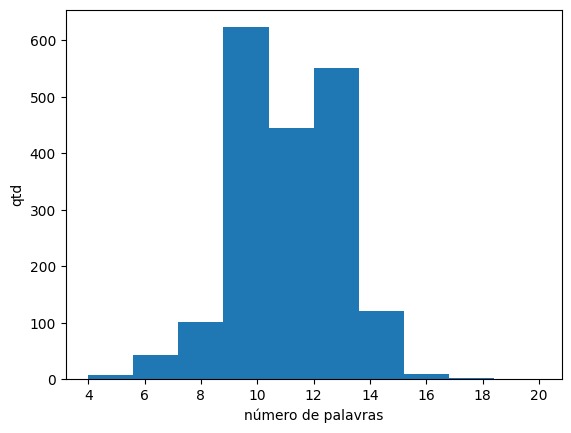

In [20]:
turismo.title_n_words.hist();
plt.xlabel('número de palavras')
plt.ylabel('qtd')
plt.grid(False)
plt.show()

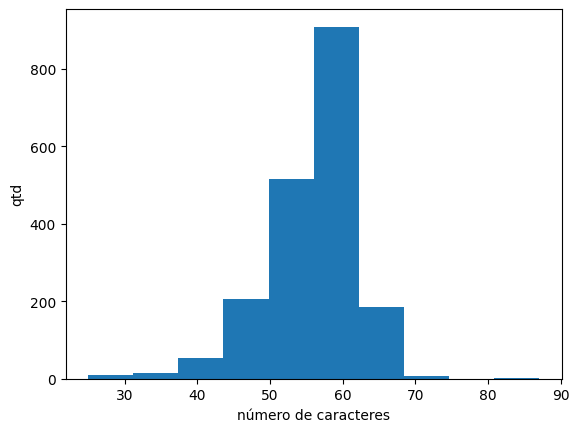

In [21]:
turismo.title_n_chars.hist();
plt.xlabel('número de caracteres')
plt.ylabel('qtd')
plt.grid(False)
plt.show()

## Limpeza dos dados

In [22]:
nlp_pt = spacy.load('pt_core_news_sm')

In [23]:
rev = turismo.iloc[0]['title']
print(rev)

Latam inaugura voo direto de 15 horas entre Chile e Austrália


In [24]:
rev = limpa_texto(rev)
print (rev)

latam inaugura voo direto de 15 horas entre chile e austrália


In [25]:
rev2 = turismo.iloc[5]['title']
print(rev2)

'Viagem ao Japão é aula de cultura e tradição', diz ator Jayme Matarazzo


In [26]:
limpa_texto(rev2)

'viagem ao japão é aula de cultura e tradição diz ator jayme matarazzo'

In [27]:
rev = nlp_pt(rev)

In [28]:
def exibe_token(texto):
    col_names = ['ALPHA', 'PUNCT', 'LIKE NUM', 'POS']
    formatted_text = '{:>16}' * (len(col_names)+1)
    print('\n', formatted_text.format('INPUT WORD', *col_names), '\n', '='*130)

    for token in texto:
        output = [token.text, token.is_alpha, token.is_punct, token.like_num, token.pos_]
        print(formatted_text.format(*output))

In [29]:
exibe_token(rev)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
           latam               1               0               0            VERB
        inaugura               1               0               0            VERB
             voo               1               0               0            NOUN
          direto               1               0               0             ADJ
              de               1               0               0             ADP
              15               0               0               1             NUM
           horas               1               0               0            NOUN
           entre               1               0               0             ADP
           chile               1               0               0           PROPN
               e               1               0               0           CCONJ
       austrália               1               0               0            NOUN


In [30]:
displacy.render(rev, style='dep', jupyter=True)

In [31]:
rev2 = nlp_pt(rev2)

In [32]:
exibe_token(rev2)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
               '               0               1               0           PUNCT
          Viagem               1               0               0           PROPN
              ao               1               0               0             ADP
           Japão               1               0               0           PROPN
               é               1               0               0             AUX
            aula               1               0               0            NOUN
              de               1               0               0             ADP
         cultura               1               0               0            NOUN
               e               1               0               0           CCONJ
        tradição               1               0               0            NOUN
               '               0               1               0           PUNCT
               ,         

In [33]:
displacy.render(rev2, style='dep', jupyter=True)

In [34]:
turismo['title_clean'] = turismo['title'].apply(lambda x: limpa_texto(x))

In [35]:
turismo

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...
...,...,...,...,...,...,...,...,...,...
166982,Fotógrafo Gustavo Epifanio foi a cidades da co...,O fotógrafo Gustavo Epifanio fez uma viagem de...,2015-01-01,turismo,NaN,http://www1.folha.uol.com.br/turismo/2015/01/1...,10,56,fotógrafo gustavo epifanio foi a cidades da co...
167005,Conheça dez rituais tradicionais de passagem d...,"Bater panelas nas janelas, quebrar pratos em f...",2015-01-01,turismo,NaN,http://www1.folha.uol.com.br/turismo/2015/01/1...,12,58,conheça dez rituais tradicionais de passagem d...
167007,Metrô de Londres vai ficar mais barato para tu...,"Londres, que tem um dos sistemas de transporte...",2015-01-01,turismo,NaN,http://www1.folha.uol.com.br/turismo/2015/01/1...,11,52,metrô de londres vai ficar mais barato para tu...
167011,Redes estrangeiras de hotéis econômicos amplia...,"A estrutura hoteleira do país, que tem ganhado...",2015-01-01,turismo,NaN,http://www1.folha.uol.com.br/turismo/2015/01/1...,9,56,redes estrangeiras de hotéis econômicos amplia...


In [36]:
turismo['title_clean_no_stop'] = turismo['title_clean'].apply(lambda x: remove_stop(x))

In [37]:
turismo.iloc[0]['title_clean']

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [38]:
turismo.iloc[0]['title_clean_no_stop']

'latam inaugura voo direto 15 horas chile austrália'

In [39]:
# Lematização

turismo['title_lemmas'] = turismo['title_clean_no_stop'].apply(lambda x : limpa_texto2(x))

In [40]:
turismo.iloc[0]['title_lemmas']

'latar inaugurar voo direto 15 hora chile austrália'

In [41]:
turismo.iloc[5]['title_lemmas']

'viagem Japão aular Cultura tradição ator Jayme Matarazzo'

# N-grams

In [42]:
titulos = " ".join(turismo['title_lemmas'])

In [43]:
token = word_tokenize(titulos)

In [44]:
bigramas = ngrams(token, 2)

In [45]:
print(Counter(bigramas).most_common(10))

[(('fotógrafo', 'registrar'), 31), (('álbum', 'viagem'), 22), (('atrair', 'turista'), 19), (('companhia', 'aéreo'), 18), (('fotógrafo', 'clicar'), 11), (('atração', 'turístico'), 10), (('levar', 'turista'), 10), (('estação', 'esqui'), 10), (('opção', 'pacote'), 9), (('parque', 'temático'), 8)]


In [46]:
trigrams = ngrams(token, 3)

In [47]:
print(Counter(trigrams).most_common(10))

[(('fotógrafo', 'registrar', 'paisagem'), 4), (('tema', 'ensaio', 'fotográfico'), 4), (('parque', 'harryr', 'potter'), 4), (('ter', 'montanha', 'russo'), 3), (('mundo', 'fotógrafo', 'registrar'), 3), (('pacote', 'último', 'hora'), 3), (('último', 'hora', 'viajar'), 3), (('país', 'álbum', 'viagem'), 3), (('inaugurar', 'museu', 'dedicar'), 3), (('World', 'trade', 'center'), 3)]


In [48]:
vectorizer = CountVectorizer(min_df = 10, max_df = 0.9, stop_words=list(STOP_WORDS) ,lowercase = True)

In [49]:
data_vectorizer = vectorizer.fit_transform(turismo['title_lemmas'])

In [50]:
NUM_TOPICS =2

In [51]:
lda = LatentDirichletAllocation (n_components=NUM_TOPICS, max_iter=30, learning_method='online', verbose=True)

In [52]:
data_lda = lda.fit_transform(data_vectorizer)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


In [53]:
pyLDAvis.enable_notebook()

In [54]:
dash = pyLDAvis.lda_model.prepare(lda, data_vectorizer, vectorizer, mds= 'tsne')

In [55]:
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      13.141898 -30.803396       1        1  50.472274
0     -13.141593  30.803640       2        1  49.527726, topic_info=          Term        Freq       Total Category  logprob  loglift
192    turista  176.000000  176.000000  Default  30.0000  30.0000
191    turismo  113.000000  113.000000  Default  29.0000  29.0000
104      hotel  103.000000  103.000000  Default  28.0000  28.0000
92   fotógrafo   83.000000   83.000000  Default  27.0000  27.0000
125      mundo   79.000000   79.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
163       rede   17.057713   17.621356   Topic2  -4.9837   0.6701
104      hotel   98.765102  103.190976   Topic2  -3.2276   0.6588
165     região   21.337609   22.809079   Topic2  -4.7599   0.6360
20     atração   36.295663   56.258684   Topic2  -4.2286   0.2644
133   oferecer   22.145713   39.167462   Topic2  -4.7227   0.1324

[99 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         1  0.980762      abrir
5         2  0.025810      abrir
6         1  0.047147  aeroporto
6         2  0.990079  aeroporto
8         1  0.985076     airbnb
...     ...       ...        ...
199       2  0.990950     viajar
203       1  0.974663  visitante
203       2  0.036099  visitante
213       1  0.974510      álbum
213       2  0.037481      álbum

[137 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])